## Entering the gene expression data

In [1]:
import pandas as pd
xls = 'data.xlsx'
df1 = pd.read_excel(xls, 'Gene1')
df2 = pd.read_excel(xls, 'Gene2')
df3 = pd.read_excel(xls, 'Gene3')
df4 = pd.read_excel(xls, 'Gene4')
df5 = pd.read_excel(xls, 'Gene5')

df1

,Condition 1,Condition 2
0,2.356730,55.4849
1,10.513600,25.2013
2,2.306840,32.8903
3,0.684857,59.3853
4,5.468820,26.0129
5,-0.771883,41.1049
6,14.440100,53.1026
7,24.562100,69.4246
8,7.446040,39.4843
9,0.516585,36.0090


## Visualization

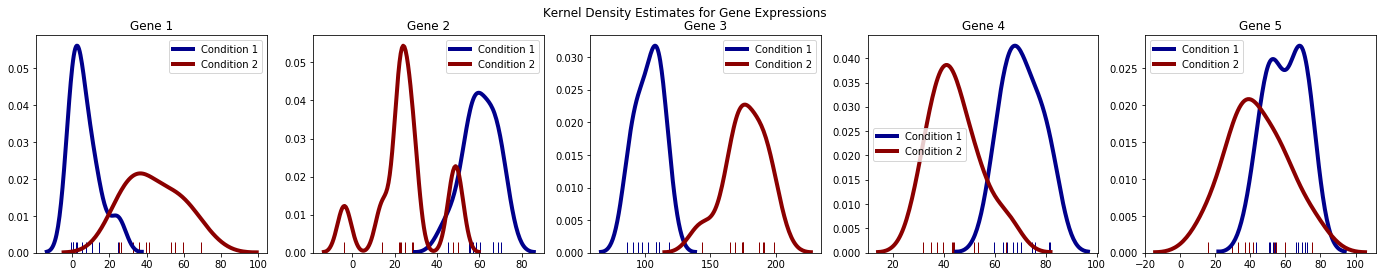

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 5, sharex=False, figsize=(24, 4))
fig.suptitle('Kernel Density Estimates for Gene Expressions')

i = 0
for df in [df1, df2, df3, df4, df5]:
    axes[i].set_title(f'Gene {i+1}')
    sns.distplot(ax=axes[i], a = df['Condition 1'], hist=False, kde_kws={'linewidth':4}, color='darkblue', label = 'Condition 1', axlabel=False, rug=True)
    sns.distplot(ax=axes[i], a = df['Condition 2'], hist=False, kde_kws={'linewidth':4}, color='darkred', label='Condition 2', axlabel=False, rug=True)
    i += 1


## Anderson-Darling Test for normality

In [3]:
from scipy.stats import anderson
i = 1
for df in [df1, df2, df3, df4, df5]:
    stat, cv, siglevels = anderson(df['Condition 1'])
    if stat < cv[2]:
        print('For alpha = {}, the samples from Gene {} Condition 1 is normal'.format(siglevels[2]/100, i))
    else: 
        print('For alpha = {}, the samples from Gene {} Condition 1 is NOT normal'.format(siglevels[2]/100, i))

    stat, cv, siglevels = anderson(df['Condition 2'])
    if stat < cv[2]:
        print('For alpha = {}, the samples from Gene {} Condition 2 is normal'.format(siglevels[2]/100, i))
    else: 
        print('For alpha = {}, the samples from Gene {} Condition 2 is NOT normal'.format(siglevels[2]/100, i))
    print('\n')
    i += 1

For alpha = 0.05, the samples from Gene 1 Condition 1 is normal
For alpha = 0.05, the samples from Gene 1 Condition 2 is normal


For alpha = 0.05, the samples from Gene 2 Condition 1 is normal
For alpha = 0.05, the samples from Gene 2 Condition 2 is normal


For alpha = 0.05, the samples from Gene 3 Condition 1 is normal
For alpha = 0.05, the samples from Gene 3 Condition 2 is normal


For alpha = 0.05, the samples from Gene 4 Condition 1 is normal
For alpha = 0.05, the samples from Gene 4 Condition 2 is normal


For alpha = 0.05, the samples from Gene 5 Condition 1 is normal
For alpha = 0.05, the samples from Gene 5 Condition 2 is normal




## Variance Tests

With the normality confirmation, we can perform F-test for equal variances.

In [4]:
import scipy
import numpy as np

f_test_alpha = 0.01

def f_test(dataframe):
    f = np.var(dataframe['Condition 1'], ddof=1)/np.var(dataframe['Condition 2'], ddof=1)
    if f >= 1:
        pass
    else:
        f = 1/f
    dof1 = len(dataframe['Condition 1']) - 1 
    dof2 = len(dataframe['Condition 2']) - 1 
    p = 1 - scipy.stats.f.cdf(f, dof1, dof2) 
    return f, p

i = 1
for df in [df1, df2, df3, df4, df5]:
    f, p = f_test(df)
    print(f'Gene {i} --------------------------')
    print('Variance of Condition 1 = {} | Variance of Condition 2 = {}'.format(np.var(df['Condition 1']), np.var(df['Condition 2'])))
    print(f'F-value = {f} | p-value = {p}')

    if p <= f_test_alpha:
        print('Variances are different. Use Welch\'s test \n')
    else: 
        print('Variances are similar. Use two-sample T test \n')
    i += 1

Gene 1 --------------------------
Variance of Condition 1 = 56.39617047792109 | Variance of Condition 2 = 199.04985877090002
F-value = 3.529492465252181 | p-value = 0.03708406253203533
Variances are similar. Use two-sample T test 

Gene 2 --------------------------
Variance of Condition 1 = 53.88223246689999 | Variance of Condition 2 = 211.59415710819604
F-value = 3.9269745780889624 | p-value = 0.026977310577590452
Variances are similar. Use two-sample T test 

Gene 3 --------------------------
Variance of Condition 1 = 92.09885198249998 | Variance of Condition 2 = 230.28384116000007
F-value = 2.5003986065293966 | p-value = 0.09418980056691528
Variances are similar. Use two-sample T test 

Gene 4 --------------------------
Variance of Condition 1 = 49.89637382400001 | Variance of Condition 2 = 85.28357848760002
F-value = 1.7092139558762665 | p-value = 0.2184042269530435
Variances are similar. Use two-sample T test 

Gene 5 --------------------------
Variance of Condition 1 = 101.282131

### Using Bartlett's test
Alternatively, one can also use Levene's test to check for homoscedasticity, but Bartlett's is more robust when the data is fairly normal.

In [5]:
b_test_alpha = 0.05
i = 1
not_eq, eq = [], []
for df in [df1, df2, df3, df4, df5]:
    stat, p = scipy.stats.bartlett(df['Condition 1'], df['Condition 2'])
    if p < b_test_alpha:
        not_eq.append(i)
    else:
        eq.append(i)
    i += 1
print('Similar Variance : Gene(s),', eq)
print('Different Variance : Gene(s),', not_eq)

Similar Variance : Gene(s), [1, 2, 3, 4, 5]
Different Variance : Gene(s), []


## Performing T tests

I've defined the tests from scratch here. One can also use ttest_ind built-in scipy.stats function (shown later).

In [6]:
from scipy.stats import t
def independent_ttest(dataframe, type):
    mean1, mean2 = np.mean(dataframe['Condition 1']), np.mean(dataframe['Condition 2'])
    std1, std2 = np.std(dataframe['Condition 1'], ddof=1), np.std(dataframe['Condition 2'], ddof=1)
    n1, n2 = len(dataframe['Condition 1']), len(dataframe['Condition 2'])
    se1, se2 = std1/np.sqrt(n1), std2/np.sqrt(n2)
    sed = np.sqrt(se1**2.0 + se2**2.0)
    if type == 'welch':
        deg = ((std1**2/n1 + std2**2/n2)**2)/((std1**2/n1)**2/(n1-1) + (std2**2/n2)**2/(n2-1))
    elif type == 'standard':
        deg = n1 + n2 - 2
    t_stat = (mean1 - mean2) / sed
    p = (1 - t.cdf(abs(t_stat), deg)) * 2

    return [t_stat, p]

In [12]:
result_arr = []
for df in [df1, df2, df3, df4, df5]:
    _, p = f_test(df)
    if p < f_test_alpha:
        result_arr.append(independent_ttest(df, 'welch'))
    else:
        result_arr.append(independent_ttest(df, 'standard'))
result = pd.DataFrame(result_arr, index = [f'Gene {i}' for i in range(1, 6)], columns = ['t-statistics', 'p-values'])
result

,t-statistics,p-values
Gene 1,-6.955836,1.690799e-06
Gene 2,6.383598,5.187010e-06
Gene 3,-12.337924,3.223044e-10
Gene 4,6.790191,2.328260e-06
Gene 5,2.510918,2.180714e-02


### Using the built in functions for verification


In [8]:

from scipy.stats import t, ttest_ind
for df in [df1, df2, df3, df4, df5]:
    _, p = f_test(df)
    if p < f_test_alpha:
        print(ttest_ind(df['Condition 1'], df['Condition 2'], equal_var=False)) # Welch's t test
    else: 
        print(ttest_ind(df['Condition 1'], df['Condition 2'], equal_var=True)) # Standard t test

Ttest_indResult(statistic=-6.955835941643947, pvalue=1.6907986148163585e-06)
Ttest_indResult(statistic=6.3835983268845755, pvalue=5.187010075903916e-06)
Ttest_indResult(statistic=-12.337923722659578, pvalue=3.223044229002422e-10)
Ttest_indResult(statistic=6.790191418943272, pvalue=2.3282596901689203e-06)
Ttest_indResult(statistic=2.510917707340854, pvalue=0.021807143033058408)


## Differential Genes

The familywise error rate explodes as we increase the number of comparisons. So we have to use the Bonferroni corrected value of alpha.

In [9]:
alpha = 0.05
sig_level = alpha / 5 # Bonferroni corrected value
sorted_result = result.sort_values('p-values').loc[result['p-values'] < sig_level]
print('\n Number of differential genes:', len(sorted_result))
sorted_result


 Number of differential genes: 4


,t-statistics,p-values
Gene 3,-12.337924,3.223044e-10
Gene 1,-6.955836,1.690799e-06
Gene 4,6.790191,2.328260e-06
Gene 2,6.383598,5.187010e-06


In [10]:
print("Highest p-value that can pass through Bonferroni :", sorted_result['p-values'].max())

Highest p-value that can pass through Bonferroni : 5.187010075902165e-06
